# **DATA MINING CSE 572 : Group Project : Final Report Code**

## **Group Members**

1.   Rushir Bhavsar rbhavsa4@asu.edu
2.   Maisuria Hardik Dharmeshkumar hmaisuri@asu.edu
3.   Shivam Hasmukh Panchal spanch13@asu.edu
4.   Neel Kunjadiya nkunjadi@asu.edu
5.   Dhruvil Gorasiya dgorasiy@asu.edu

#### **Problem Topic:** Lyrics Mood Classification using combination of ML and DL algorithms



## **Pre-limnary Libraries**

In [ ]:
from IPython.display import clear_output
!pip install lyricsgenius
!pip install langdetect
!pip install datasets
!pip install gdown
from zipfile import ZipFile
import lyricsgenius as genius
from lyricsgenius import OAuth2
import concurrent.futures
import requests
import sys
import os
import gdown
import zipfile
import time
import threading
import asyncio
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from multiprocessing import Pool
from asyncio import Semaphore
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import csv
from langdetect import detect, LangDetectException
import json
import sqlite3

# Setup tqdm for pandas apply
tqdm.pandas(desc="Processing lyrics")


clear_output()

## **Data Creation, Preproc and Word Embedding Routine**
The Code has been commented as the dataset is already provided and the code runtime complexity is in hours, however it has been provided here for assessment purposes

#### **Helper Functions**

In [ ]:
# ## Helper Function
# def sanitize(tag):
#     return tag.replace("'", "''")

# def match_song_tags_to_mood_expanded(tags):
#     matched_mood = 'unknown'
#     matched_moods = 0
#     mood_scoreboard = {mood: 0 for mood in MOOD_CATEGORIES_EXPANDED}
#     for mood, (keywords, like_queries, filters) in MOOD_CATEGORIES_EXPANDED.items():
#         for keyword in keywords:
#             if keyword in tags:
#                 mood_scoreboard[mood] += 1
#         for like_query in like_queries:
#             matches = tags.str.contains(like_query)
#             for tag in tags[matches]:
#                 if not any(f in tag for f in filters):
#                     mood_scoreboard[mood] += 1
#     max_score = max(mood_scoreboard.values())
#     if max_score > 0:
#         matched_moods = 1
#         matched_mood = max((mood for mood, score in mood_scoreboard.items() if score == max_score), default='unknown')
#     return matched_mood, matched_moods


#### **Main Functions for Dataset generation**

In [ ]:
"""1. Downloads Dataset from two specified URLs of LastFM Dataset and MSD Dataset """
def manage_datasets(data_dir, data_urls):
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    for datasrc, split, url, dest in data_urls:
        if not os.path.exists(dest):
            response = requests.get(url)
            with open(dest, 'wb') as f:
                f.write(response.content)

        zippedfile = dest
        unzip_dest = dest[:dest.rfind('.')]
        if not os.path.exists(unzip_dest) and '.zip' in dest:
            with ZipFile(zippedfile, 'r') as zip_ref:
                zip_ref.extractall(unzip_dest)

"""2. Scrape through the Genius Website using LyricsGenius API to search for songs """

"""2a. Generates safe API requests to avoid timeouts and retries in case the request gets timedout """
def safe_api_request(api, title, artist, retries=2):
    """Attempts to safely perform API requests with specified retries and timeout."""
    while retries > 0:
        try:
            song = api.search_song(title, artist)
            return song

        except requests.RequestException as e:
            retries -= 1
            if retries == 0:
                return None
            return None

"""2b. Generates Lyric file name with all characters remove and cleaned """
def make_lyric_file_name(artist, title):
    """Create a filename-friendly version of the song details."""
    # return f"{artist}___{title}".replace(' ', '_').replace('/', '_').replace('/', '_').replace('\\', '_').replace(':', '_').replace('*', '_').replace('?', '_').replace('"', '_').replace('<', '_').replace('>', '_').replace('|', '_')
    keepcharacters = ('_')
    filename = '{0}___{1}'.format(str(artist).replace(' ', '_'), str(title).replace(' ', '_'))
    return "".join(c for c in filename if c.isalnum() or c in keepcharacters).rstrip()

"""2c. Downloads lyrics and stores them in text format for future use """
def download_lyric(row, api, known_bad, existing_files):
    artist = row['msd_artist']
    title = row['msd_title']


    json_lyricfile = os.path.join("/content/data/json", f"{make_lyric_file_name(artist, title)}.txt")
    txt_lyricfile = os.path.join("/content/data/txt", f"{make_lyric_file_name(artist, title)}.txt")

    # Check against in-memory structures for redundancy
    if json_lyricfile in existing_files or (artist, title) in known_bad:
        return None

    song = safe_api_request(api, title, artist)
    if not song:
        return row  # Return the row to be added to no lyrics file
    song.save_lyrics(filename=txt_lyricfile, overwrite=True, verbose=False, extension='txt', sanitize=False)
    return None

"""2d. Main Scraping procedure function to get the lyrics and map them with the Musixmatch MSD dataset """
def scrape_lyrics_procedure():
    os.makedirs("/content/data/json", exist_ok=True)
    os.makedirs("/content/data/txt", exist_ok=True)

    if not os.path.exists("/content/data/mxm_mappings.csv"):
        if not os.path.exists("/content/data/musixmatch_matches.txt/mxm_779k_matches.txt"):
            return "Musixmatch mapping file not found."
        with open("/content/data/mxm_mappings.csv", 'w', newline='', encoding='utf-8') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(CSV_HEADER)
            with open("/content/data/musixmatch_matches.txt/mxm_779k_matches.txt", 'r', encoding='utf-8') as f:
                for line in f:
                    if not line.startswith('#'):
                        parts = line.strip().split('<SEP>')
                        if len(parts) == len(['msd_id', 'msd_artist', 'msd_title', 'mxm_id', 'mxm_artist', 'mxm_title']):
                            writer.writerow(parts)

    df = pd.read_csv("/content/data/mxm_mappings.csv", encoding='utf-8', dtype={'msd_artist': str, 'msd_title': str})

    # Pre-load known bad entries and existing files
    existing_files = {os.path.join("/content/data/json", f) for f in os.listdir("/content/data/json") if f.endswith('.json')}
    known_bad = set()

    api = genius.Genius(API_TOKEN, verbose=False)

    with ThreadPoolExecutor(max_workers=100) as executor:
        futures = [executor.submit(download_lyric, row, api, known_bad, existing_files) for _, row in df.iterrows()]
        no_lyrics_updates = []
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(df), desc="Downloading Lyrics"):
            result = future.result()
            if result is not None:
                pass
    print("Lyrics scraping process completed.")

"""3. Indexes the songs to check which songs has their lyrics download and which one has not. """
def index_lyrics_procedure(csv_input="/content/data/mxm_mappings.csv", csv_output="/content/data/index_lyrics.csv", artist_first_letter=None):
    df = pd.read_csv(csv_input, encoding='utf-8', dtype = {'msd_artist':str, 'msd_title': str})

    # Setting initial values in DataFrame to avoid repetitive calls inside the loop
    df['lyrics_filename'] = df.apply(lambda x: make_lyric_file_name(x['msd_artist'], x['msd_title'])+'.txt', axis=1)
    df['lyrics_available'] = 0
    df['wordcount'] = 0
    df['is_english'] = 0
    df = df.sort_values(by=['lyrics_filename'])
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Lyrics Files"):
        txt_lyricfile = os.path.join("/content/data/txt", row['lyrics_filename'])
        if os.path.exists(txt_lyricfile):
            try:
                with open(txt_lyricfile, 'r', encoding='latin-1') as file:
                    contents = file.read()
                    if contents:
                        df.at[index, 'lyrics_available'] = 1
                        try:
                            lang = detect(contents)
                            df.at[index, 'is_english'] = 1 if lang == 'en' else 0
                        except LangDetectException:
                            print(f"Language detection failed for {txt_lyricfile}")
                        df.at[index, 'wordcount'] = len(contents.split())
            except Exception as e:
                print(f"Failed to read {txt_lyricfile}: {e}")

    print("Lyrics processing completed.")

    df.to_csv(csv_output, index=False)

"""4. Labels the song names and mood annotates the whole dataset"""
def label_lyrics_expanded():
    df = pd.read_csv("/content/data/index_lyrics.csv", dtype=str)
    df['mood'] = 'unknown'
    df['matched_mood'] = 0
    df['found_tags'] = 0
    conn = sqlite3.connect("/content/data/mxm_mappings.csv")

    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing - Labelling Lyrics"):
        if df.at[index, 'lyrics_available'] == "1":
            msd_id = sanitize(row['msd_id'])
            sql = "SELECT tids.tid, tags.tag, tid_tag.val FROM tid_tag, tids, tags WHERE tids.ROWID=tid_tag.tid AND tid_tag.tag=tags.ROWID AND tids.tid='{0}'".format(sanitize(msd_id))
            tags = pd.read_sql_query(sql, conn)['tag']
            df.loc[index, 'found_tags'] = len(sql)
            if len(sql) != 0:
                df.at[index, 'mood'], df.loc[index, 'matched_mood'] = match_song_tags_to_mood_expanded(tags)
    conn.close()
    df.to_csv("/content/data/labeled_lyrics.csv", index=False)

#### **Following steps have been commented out as they create the dataset. However for our purpose we have simply used the pre-generated dataset in this notebook. We would suggest to skip running this code as Colab Internet Network would also not allow the request throughput that would used on a local PC.**



In [ ]:
# manage_datasets(DATA_DIR, DATA_URLS)
# Average Time taken for this step: 10 seconds - 1 minute

In [ ]:
# scrape_lyrics_procedure()
# Average Time taken for this step: 10 - 12 hours

In [ ]:
# index_lyrics_procedure()
# Average Time taken for this step: 10 minutes

In [ ]:
# label_lyrics_expanded()
# Average Time taken for this step: 15 minutes

## **Downloading the Preprocessed Dataset from Google Drive**

In [ ]:
file_path = "labeled_lyrics.csv.zip"
gdown.download("https://drive.google.com/uc?export=download&id=1ALaVAqxg3odTJl7sSGL8y8hRQDL714c5", file_path, quiet=False)
# Read the zipfile from the downloaded file
with zipfile.ZipFile(file_path, 'r') as z:
    # Extract files to memory
    data_csv = z.open('labeled_lyrics.csv')

df = pd.read_csv(data_csv, usecols=['is_english', 'lyrics_available', 'lyrics', 'mood', 'matched_mood', 'wordcount'], low_memory=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1ALaVAqxg3odTJl7sSGL8y8hRQDL714c5
From (redirected): https://drive.google.com/uc?export=download&id=1ALaVAqxg3odTJl7sSGL8y8hRQDL714c5&confirm=t&uuid=c5253bef-0a1a-43ba-838c-eb3908ab546b
To: /content/labeled_lyrics.csv.zip
100%|██████████| 1.40G/1.40G [00:14<00:00, 97.8MB/s]


## **Model Training and Testing : Basic ML**

In [ ]:
import pandas as pd
import numpy as np
import os
import requests
import zipfile

from io import BytesIO
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import re

In [ ]:
def preprocess_text(text):
    """Advanced text preprocessing to clean and prepare text data."""
    text = text.lower()  # Convert to lower case
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

In [ ]:
def process_dataset_and_visualize_lyrics(df, mood_quad = False):

    df = df[(df.is_english == 1) & (df.matched_mood == 1)]

    # Encoding the Moods into 4 Quadrants
    if mood_quad:
        mood_mapping = {
            'aggression': 'anger',
            'angst': 'anger',
            'anger': 'anger',
            'brooding': 'calm',
            'calm': 'calm',
            'cheerful': 'happy',
            'confident': 'calm',
            'depressed': 'sad',
            'desire': 'calm',
            'dreamy': 'calm',
            'earnest': 'happy',
            'excitement': 'happy',
            'grief': 'sad',
            'happy': 'happy',
            'pessimism': 'sad',
            'romantic': 'happy',
            'sad': 'sad',
            'upbeat': 'calm'
        }

        # Use the replace method to map the original moods to their quadrants in one operation
        a = df['mood'].replace(mood_mapping)
        # Encode mood labels
        label_encoder = LabelEncoder()
        df['mood_cats'] = label_encoder.fit_transform(a)
    else:
      # Encode mood labels
      label_encoder = LabelEncoder()
      df['mood_cats'] = label_encoder.fit_transform(df['mood'])

    # TF-IDF Vectorization
    tfidf = TfidfVectorizer(max_features=5000, stop_words='english')  # Consider using a stop word filter to improve feature relevance
    features = tfidf.fit_transform(df['lyrics'])

    # Split the dataset
    X_train, X_temp, y_train, y_temp = train_test_split(features, df['mood_cats'], test_size=0.4, random_state=42, stratify=df['mood_cats'])
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = process_dataset_and_visualize_lyrics(df)
clear_output()

In [ ]:
X_train_m, X_val_m, X_test_m, y_train_m, y_val_m, y_test_m = process_dataset_and_visualize_lyrics(df, mood_quad=True)
clear_output()

In [ ]:
def process_lyrics_and_classify(X_train, X_val, X_test, y_train, y_val, y_test):
    models = {
        'Multinomial Naive Bayes': MultinomialNB(),
        'Complement Naive Bayes': ComplementNB(alpha=0.01),
        'Bernoulli Naive Bayes': BernoulliNB(binarize=0.0),
        'SGD Hinge': SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None),
        'SGD Grid Search': GridSearchCV(SGDClassifier(loss='hinge', random_state=42, max_iter=2000, tol=None), {'alpha': [1e-4, 1e-3, 1e-2], 'penalty': ['l2', 'l1'], 'max_iter': [5, 10, 20]}, cv=3),
        'SVC RBF': SVC(kernel='rbf', C=1.0, gamma=0.1, verbose=False, max_iter=1000),
        'Linear SVC': LinearSVC(penalty='l2', C=0.001, max_iter=1000),
        'Logistic Regression Multinomial': LogisticRegression(multi_class='multinomial', solver='newton-cg', C=1.0, penalty='l2', dual=False),
        'Logistic Regression SAGA': LogisticRegression(multi_class='multinomial', solver='saga', penalty='elasticnet', C=1.0, l1_ratio=0.5)
    }

    results = {}
    for name, model in models.items():

        print('Processing %s' % (name))
        model.fit(X_train, y_train)
        dev_pred = model.predict(X_val)
        test_pred = model.predict(X_test)

        validation_acc = accuracy_score(y_val, dev_pred)
        test_acc = accuracy_score(y_test, test_pred)
        print("Model Trained")


        results[name] = {
            'name': name,
            'val_accuracy': validation_acc,
            'test_accuracy': test_acc
        }
    return models, results

In [ ]:
# Training Models with Segregation of Moods
models, results = process_lyrics_and_classify(X_train, X_val, X_test, y_train, y_val, y_test)
clear_output()
for name, _ in models.items():
        # Print accuracy
        print(f"{results[name]['name']} - Validation Accuracy: {results[name]['val_accuracy']:.4f}, Test Accuracy: {results[name]['test_accuracy']:.4f}")

Multinomial Naive Bayes - Validation Accuracy: 0.3679, Test Accuracy: 0.3681
Complement Naive Bayes - Validation Accuracy: 0.3898, Test Accuracy: 0.4052
Bernoulli Naive Bayes - Validation Accuracy: 0.1324, Test Accuracy: 0.1332
SGD Hinge - Validation Accuracy: 0.4669, Test Accuracy: 0.4663
SGD Grid Search - Validation Accuracy: 0.4777, Test Accuracy: 0.4876
SVC RBF - Validation Accuracy: 0.3649, Test Accuracy: 0.3869
Linear SVC - Validation Accuracy: 0.3221, Test Accuracy: 0.3223
Logistic Regression Multinomial - Validation Accuracy: 0.4427, Test Accuracy: 0.4521
Logistic Regression SAGA - Validation Accuracy: 0.4259, Test Accuracy: 0.4294


In [ ]:
# Training Models with Grouping of Moods into 4 quadrants
models, results = process_lyrics_and_classify(X_train_m, X_val_m, X_test_m, y_train_m, y_val_m, y_test_m)
clear_output()
for name, _ in models.items():
        # Print accuracy
        print(f"{results[name]['name']} - Validation Accuracy: {results[name]['val_accuracy']:.4f}, Test Accuracy: {results[name]['test_accuracy']:.4f}")

Multinomial Naive Bayes - Validation Accuracy: 0.5045, Test Accuracy: 0.5000
Complement Naive Bayes - Validation Accuracy: 0.4679, Test Accuracy: 0.4822
Bernoulli Naive Bayes - Validation Accuracy: 0.2613, Test Accuracy: 0.2625
SGD Hinge - Validation Accuracy: 0.5184, Test Accuracy: 0.5234
SGD Grid Search - Validation Accuracy: 0.5486, Test Accuracy: 0.5533
SVC RBF - Validation Accuracy: 0.4344, Test Accuracy: 0.4397
Linear SVC - Validation Accuracy: 0.4280, Test Accuracy: 0.4279
Logistic Regression Multinomial - Validation Accuracy: 0.5509, Test Accuracy: 0.5515
Logistic Regression SAGA - Validation Accuracy: 0.5310, Test Accuracy: 0.5412


## **CNN : Processing Dataset and Training the CNN Model**

In [ ]:
!pip install gensim
clear_output()

In [ ]:
import numpy as np
import collections
import gensim.downloader as api
import string
from sklearn.preprocessing import normalize
from gensim.models import Word2Vec
from nltk.corpus import stopwords
import nltk
from gensim.models import FastText
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize

# Ensure you have the necessary NLTK data downloaded
nltk.download('stopwords')
nltk.download('punkt')  # For word_tokenize
clear_output()

In [ ]:
def preprocess_lyrics(lyrics, word_tokenizer, remove_stop=True, remove_punc=True, do_padding=False, cutoff=None):
    """
    Processes lyrics by tokenizing and optionally removing stopwords and punctuation, and padding.

    Args:
        lyrics (str): Lyrics to process.
        word_tokenizer (callable): Function to tokenize words.
        remove_stop (bool): If True, removes stopwords.
        remove_punc (bool): If True, removes punctuation.
        do_padding (bool): If True, pads the end of lyrics to the specified cutoff.
        cutoff (int): Pad limit.

    Returns:
        list: Processed list of tokens.
    """
    # Prepare the stop set if necessary
    stop = set()
    if remove_stop:
        stop.update(stopwords.words('english'))
    if remove_punc:
        stop.update(string.punctuation)

    # Tokenize and remove unwanted tokens
    tokens = [token for token in word_tokenizer(lyrics.lower()) if token not in stop]

    # Handle padding
    if do_padding and cutoff:
        tokens = (tokens + ['<PAD>'] * cutoff)[:cutoff]

    return tokens

In [ ]:
def data_preparation(df, regen_embeddings=False):
    """
    Processes and prepares the lyrics dataset from CSV to a vectorized format ready for machine learning models.

    Args:
        csv_path (str): Path to the CSV file containing lyrics data.
        lyrics_dir (str): Directory where lyrics files are stored.
        vocab_size (int): Number of words to keep in the vocabulary.
        regen_embeddings (bool): Flag to regenerate embeddings if True; otherwise, attempt to load existing ones.

    Returns:
        tuple: Contains three elements (X, Y, model) where X is the features matrix,
               Y is the target labels, and model is the trained Word2Vec model.
    """
    # Import lyrics data
    # Filter the data
    df = df[df['is_english'] == 1]
    df = df[df['lyrics_available'] == 1]
    df = df[df['matched_mood'] == 1]
    df = df.drop(['is_english', 'lyrics_available', 'matched_mood'], axis=1)
    print("Data Filtered : ",df.shape)

    # Extract and preprocess lyrics
    print("Extracting and preprocessing lyrics")
    cutoff = int(df['wordcount'].quantile(0.75))
    print("Cutoff Calculated") # Ensure cutoff is an integer
    df['preprocessed_lyrics'] = df['lyrics'].apply(
        lambda lyrics: preprocess_lyrics(lyrics, word_tokenize, do_padding=True, cutoff=cutoff)
    )

    # Extract words from lyrics for embedding training
    words = [word for sublist in df['preprocessed_lyrics'].tolist() for word in sublist]

    # Initialize or load Word2Vec model
    if regen_embeddings:
        print('Training Word2Vec...')
        model = Word2Vec(sentences=[words], vector_size=50, window=5, min_count=1, workers=10, max_vocab_size=10000)
        model.train([words], total_examples=len(words), epochs=10)
    else:
        try:
            if os.path.exists("/content/trained_word2vec.model"):
              model = Word2Vec.load("/content/trained_word2vec.model")
            else:
              file_path = "trained_word2vec.model.zip"
              gdown.download("https://drive.google.com/uc?export=download&id=1P3fez5sKEXH1tnnK9Vdecf8gy9Qx8-B3", file_path, quiet=False)
              # Read the zipfile from the downloaded file
              with zipfile.ZipFile(file_path, 'r') as z:
                  z.extractall(".")
              model = Word2Vec.load("/content/trained_word2vec.model")

        except FileNotFoundError:
            print("Model file not found. Set regen_embeddings=True to train a new model.")
            return None

    # Vectorize lyrics using the trained or loaded embeddings
    df['vectorized_lyrics'] = df['preprocessed_lyrics'].apply(lambda lyrics: transform_lyrics_to_vectors(lyrics, model))

    # Prepare feature matrix X and labels Y
    X = np.array(list(df['vectorized_lyrics'].apply(np.array)))

    return X

def transform_lyrics_to_vectors(lyrics, model):
    """
    Transform lyrics to vectors using a trained Word2Vec model.

    Args:
        lyrics (list of str): Preprocessed lyrics data.
        model (Word2Vec): Trained Word2Vec model.

    Returns:
        ndarray: Array of word vectors representing the lyrics.
    """
    vectorized_lyrics = []
    for word in lyrics:
        if word in model.wv:
            vectorized_lyrics.append(model.wv[word])
        else:
            vectorized_lyrics.append(np.zeros(model.vector_size))
    return np.array(vectorized_lyrics)

In [ ]:
X = data_preparation(df, regen_embeddings=True)
clear_output()

In [ ]:
def train_and_evaluate_lyrics_cnn(X_train, y_train, X_val, y_val, X_test, y_test, BATCH_SIZE, EPOCHS):
    """
    Initializes, trains, and evaluates a CNN model for lyrics mood classification.

    Args:
        X_train, y_train: Training data and labels.
        X_val, y_val: Development data and labels.
        X_test, y_test: Testing data and labels.
    """
    # Define static CNN architecture
    shp = np.shape(X_train)
    input_layer = tf.keras.layers.Input(shape=(shp[1], shp[2], 1))  # Adjusted for convolution

    # Reshape to remove the last dimension and fit Conv1D input requirements
    reshape_layer = tf.keras.layers.Reshape((shp[1], shp[2]))(input_layer)

    conv1 = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='valid')(reshape_layer)
    pool1 = tf.keras.layers.MaxPooling1D(2)(conv1)
    dropout1 = tf.keras.layers.Dropout(0.75)(pool1)

    conv2 = tf.keras.layers.Conv1D(128, 4, activation='relu', padding='valid')(dropout1)
    pool2 = tf.keras.layers.MaxPooling1D(2)(conv2)

    conv3 = tf.keras.layers.Conv1D(128, 4, activation='relu', padding='valid')(pool2)
    pool3 = tf.keras.layers.MaxPooling1D(2)(conv3)
    dropout3 = tf.keras.layers.Dropout(0.75)(pool3)

    conv4 = tf.keras.layers.Conv1D(256, 4, activation='relu', padding='valid')(dropout3)
    pool4 = tf.keras.layers.MaxPooling1D(2)(conv4)

    conv5 = tf.keras.layers.Conv1D(128, 4, activation='relu', padding='valid')(pool4)
    pool5 = tf.keras.layers.MaxPooling1D(2)(conv5)

    conv6 = tf.keras.layers.Conv1D(128, 4, activation='relu', padding='valid')(pool5)
    pool6 = tf.keras.layers.MaxPooling1D(2)(conv6)
    dropout6 = tf.keras.layers.Dropout(0.75)(pool6)

    # Flatten and Dense Layers
    flatten = tf.keras.layers.Flatten()(dropout6)
    dense1 = tf.keras.layers.Dense(64, activation='relu')(flatten)
    dropout_final = tf.keras.layers.Dropout(0.1)(dense1)
    output = tf.keras.layers.Dense(y_train.shape[1], activation='softmax')(dropout_final)

    # Compile the model
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val))

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

    # Predict probabilities for ROC curve
    predictions = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, predictions, multi_class='ovr')
    print(f"ROC-AUC Score: {roc_auc}")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test.ravel(), predictions.ravel())
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.savefig("CNN-Mood.png", dpi = 1200)
    plt.show()

    return model

Epoch 1/30
364/364 [==============================] - 14s 14ms/step - loss: 2.2545 - accuracy: 0.2883 - val_loss: 2.2038 - val_accuracy: 0.3169
Epoch 2/30
364/364 [==============================] - 4s 11ms/step - loss: 2.0589 - accuracy: 0.3166 - val_loss: 2.0372 - val_accuracy: 0.3169
Epoch 3/30
364/364 [==============================] - 4s 10ms/step - loss: 2.0327 - accuracy: 0.3154 - val_loss: 2.0240 - val_accuracy: 0.3169
Epoch 4/30
364/364 [==============================] - 4s 10ms/step - loss: 2.0235 - accuracy: 0.3149 - val_loss: 2.0133 - val_accuracy: 0.3169
Epoch 5/30
364/364 [==============================] - 5s 14ms/step - loss: 2.0100 - accuracy: 0.3147 - val_loss: 2.0038 - val_accuracy: 0.3169
Epoch 6/30
364/364 [==============================] - 4s 12ms/step - loss: 2.0020 - accuracy: 0.3192 - val_loss: 2.0071 - val_accuracy: 0.3169
Epoch 7/30
364/364 [==============================] - 4s 10ms/step - loss: 1.9976 - accuracy: 0.3173 - val_loss: 2.0069 - val_accuracy: 0.316

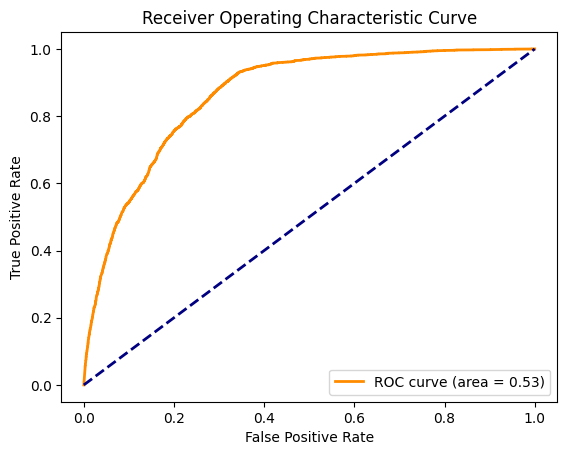

In [ ]:
# Get the Expanded Moods Y
df1 = df[(df.is_english == 1) & (df.matched_mood == 1)]
df1['mood'] = pd.Categorical(df1['mood'])
df1['mood_cats'] = df1['mood'].cat.codes
Y = pd.get_dummies(df1['mood_cats']).values
clear_output()
# Split the data X and Y into train and test and pass to the cnn model function
X_train, X_temp, y_train_m, y_temp = train_test_split(X, Y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)
m = train_and_evaluate_lyrics_cnn(X_train, y_train, X_val, y_val, X_test, y_test, 32, 30)

**Run the below code before running the above code to generate results for 4 Moods. Becuase dataset is complex and data heavy, the GPU RAM gets exhausted and the session crashes.**



In [ ]:
# # Encoding the Moods into 4 Quadrants
# mood_mapping = {
#     'aggression': 'anger',
#     'angst': 'anger',
#     'anger': 'anger',
#     'brooding': 'calm',
#     'calm': 'calm',
#     'cheerful': 'happy',
#     'confident': 'calm',
#     'depressed': 'sad',
#     'desire': 'calm',
#     'dreamy': 'calm',
#     'earnest': 'happy',
#     'excitement': 'happy',
#     'grief': 'sad',
#     'happy': 'happy',
#     'pessimism': 'sad',
#     'romantic': 'happy',
#     'sad': 'sad',
#     'upbeat': 'calm'
# }

# # Use the replace method to map the original moods to their quadrants in one operation
# df2 = df[(df.is_english == 1) & (df.matched_mood == 1)]
# df2['mood'] = df2['mood'].replace(mood_mapping)
# df2['mood'] = pd.Categorical(df2['mood'])
# df2['mood'] = df2['mood'].cat.codes
# Y_m = pd.get_dummies(df2['mood']).values
# # Split the data X and Y into train and test and pass to the cnn model function
# X_train_m, X_temp_m, y_train_m, y_temp_m = train_test_split(X, Y_m, test_size=0.4, random_state=42)
# X_val, X_test_m, y_val_m, y_test_m = train_test_split(X_temp_m, y_temp_m, test_size=0.4, random_state=42)
# m = train_and_evaluate_lyrics_cnn(X_train_m, y_train_m, X_val_m, y_val_m, X_test_m, y_test_m, 32, 30)